# Part 3: Serving

In this part you use MLRun's **serving runtime** to deploy your trained models from the previous stage, a `Voting Ensemble` using **max vote** logic.
You also use MLRun's **Feature store** to receive the latest tag of the online **Feature Vector** you defined in the previous stage.

By the end of this tutorial you’ll learn how to:
- Define a model class to load your models, run preprocessing, and predict on the data
- Define a Voting Ensemble function on top of your models
- Test the serving function locally using your `mock server`
- Deploy the function to the cluster and test it live

## Environment setup

First, make sure SciKit-Learn is installed in the correct version:

In [1]:
!pip install -U scikit-learn

Restart your kernel post installing.
Since your work is done in this project scope, you should define the project itself for all your MLRun work in this notebook.

In [2]:
project_name = "fraud-demo"

In [3]:
import mlrun

# Initialize the MLRun project object
project = mlrun.get_or_create_project(project_name, context="./", user_project=True)

> 2023-02-15 14:48:31,777 [info] loaded project fraud-demo from MLRun DB


## Define model class
- Load models
- Predict from the feature store online service via the `source` key

In [4]:
# mlrun: start-code

In [5]:
import numpy as np
from cloudpickle import load
from mlrun.serving.v2_serving import V2ModelServer


class ClassifierModel(V2ModelServer):
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model(".pkl")
        self.model = load(open(model_file, "rb"))

    def predict(self, body: dict) -> list:
        """Generate model predictions from sample"""
        print(f"Input -> {body['inputs']}")
        feats = np.asarray(body["inputs"])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

In [6]:
# mlrun: end-code

## Define a serving function

MLRun serving can produce managed real-time serverless pipelines from various tasks, including MLRun models or standard model files.
The pipelines use the Nuclio real-time serverless engine, which can be deployed anywhere.
[Nuclio](https://nuclio.io/) is a high-performance open-source serverless framework that's focused on data, I/O, and compute-intensive workloads.

The **EnrichmentVotingEnsemble** and the **EnrichmentModelRouter** router classes auto-enrich the request with data from the feature store.
The router input accepts a list of inference requests (each request can be a dict or list of incoming features/keys). It enriches the request with data from the specified feature vector (`feature_vector_uri`).

In many cases the features can have null values (None, NaN, Inf, ..). The `Enrichment` routers can substitute the null 
value with fixed or statistical value per feature. This is done through the `impute_policy` parameter, which accepts the 
impute policy per feature (where `*` is used to specify the default). The value can be a fixed number for constants or 
`$mean`, `$max`, `$min`, `$std`, `$count` for statistical values, to substitute the value with the equivalent feature stats (taken from the feature store).  

The following code achieves:

- Gather ClassifierModel code from this notebook
- Define `EnrichmentVotingEnsemble` - Max-Vote based ensemble with feature enrichment and imputing
- Add the previously trained models to the ensemble

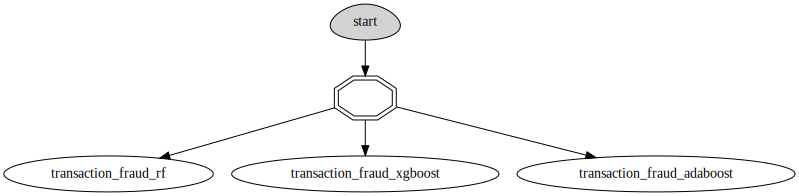

In [7]:
# Create the serving function from your code above
serving_fn = project.set_function(
    name="transaction-fraud", kind="serving", image="mlrun/mlrun"
).apply(mlrun.auto_mount())

serving_fn.set_topology(
    "router",
    "mlrun.serving.routers.EnrichmentVotingEnsemble",
    name="VotingEnsemble",
    feature_vector_uri="transactions-fraud-short",
    impute_policy={"*": "$mean"},
)

model_names = [
    "transaction_fraud_rf",
    "transaction_fraud_xgboost",
    "transaction_fraud_adaboost",
]

for i, name in enumerate(model_names, start=1):
    serving_fn.add_model(
        name,
        class_name="ClassifierModel",
        model_path=project.get_artifact_uri(f"{name}#{i}:latest"),
    )

# Plot the ensemble configuration
serving_fn.spec.graph.plot()

## Test the server locally

Before deploying the serving function, you can test it in the current notebook and check the model output.

In [8]:
# Create a mock server from the serving function
local_server = serving_fn.to_mock_server()

> 2023-02-15 14:48:36,438 [info] model transaction_fraud_rf was loaded
> 2023-02-15 14:48:36,482 [info] model transaction_fraud_xgboost was loaded
> 2023-02-15 14:48:36,520 [info] model transaction_fraud_adaboost was loaded


In [9]:
# Choose an id for your test
sample_id = "C1000148617"

model_inference_path = "/v2/models/infer"

# Send your sample ID for prediction
local_server.test(path=model_inference_path, body={"inputs": [[sample_id]]})

# notice the input vector is printed 3 times (once per child model) and is enriched with data from the feature store

Input -> [[60.98, 73.78999999999999, 2.0, 36.894999999999996, 134.16, 1037.48, 32.0, 32.42125, 143.87, 1861.8400000000001, 59.0, 31.556610169491528, 90.0, 1.0, 2.0]]
Input -> [[60.98, 73.78999999999999, 2.0, 36.894999999999996, 134.16, 1037.48, 32.0, 32.42125, 143.87, 1861.8400000000001, 59.0, 31.556610169491528, 90.0, 1.0, 2.0]]Input -> [[60.98, 73.78999999999999, 2.0, 36.894999999999996, 134.16, 1037.48, 32.0, 32.42125, 143.87, 1861.8400000000001, 59.0, 31.556610169491528, 90.0, 1.0, 2.0]]



X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names


{'id': '5237524f362a47b78828d9d7f7f87d9a',
 'model_name': 'VotingEnsemble',
 'outputs': [0],
 'model_version': 'v1'}

### Accessing the real-time feature vector directly

You can also directly query the feature store values using the `get_online_feature_service` method. This method is used internally in the EnrichmentVotingEnsemble router class.

In [10]:
import mlrun.feature_store as fstore

# Create the online feature service
svc = "transactions-fraud-short:latest".get_online_feature_service(
    impute_policy={"*": "$mean"}
)

# Get sample feature vector
sample_fv = svc.get([{"source": sample_id}])
sample_fv

[{'amount_max_2h': 60.98,
  'amount_max_12h': 134.16,
  'amount_max_24h': 143.87,
  'amount_sum_2h': 73.78999999999999,
  'amount_sum_12h': 1037.48,
  'amount_sum_24h': 1861.8400000000001,
  'amount_count_2h': 2.0,
  'amount_count_12h': 32.0,
  'amount_count_24h': 59.0,
  'es_transportation_sum_14d': 90.0,
  'es_health_sum_14d': 1.0,
  'es_otherservices_sum_14d': 2.0,
  'amount_avg_2h': 36.894999999999996,
  'amount_avg_12h': 32.42125,
  'amount_avg_24h': 31.556610169491528}]

## Deploying the function on the Kubernetes cluster

You can now deploy the function. Once deployed, you get a function with http trigger that can be called from other locations.

Model activities can be tracked into a real-time stream and time-series DB. The monitoring data
is used to create real-time dashboards, detect drift, and analyze performance.<br>
To monitor a deployed model, apply `set_tracking()`.


In [11]:
import os

# Enable model monitoring
serving_fn.set_tracking()
project.set_model_monitoring_credentials(os.getenv("V3IO_ACCESS_KEY"))

# Deploy the serving function
serving_fn.deploy()

> 2023-02-15 14:48:36,931 [info] Starting remote function deploy
2023-02-15 14:48:39  (info) Deploying function
2023-02-15 14:48:39  (info) Building
2023-02-15 14:48:39  (info) Staging files and preparing base images
2023-02-15 14:48:39  (info) Building processor image
2023-02-15 14:50:15  (info) Build complete
2023-02-15 14:51:05  (info) Function deploy complete
> 2023-02-15 14:51:05,648 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-fraud-demo-dani-transaction-fraud.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['fraud-demo-dani-transaction-fraud-fraud-demo-dani.default-tenant.app.vmdev94.lab.iguazeng.com/']}


'http://fraud-demo-dani-transaction-fraud-fraud-demo-dani.default-tenant.app.vmdev94.lab.iguazeng.com/'

## Test the server

You can test the serving function and examine the model output.

In [12]:
# Choose an id for your test
sample_id = "C1000148617"

model_inference_path = "/v2/models/infer"

# Send your sample ID for prediction
serving_fn.invoke(path=model_inference_path, body={"inputs": [[sample_id]]})

> 2023-02-15 14:51:05,714 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-dani-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/infer'}


{'id': 'c34706e4-f1c8-4aff-b226-020c2cad7e4a',
 'model_name': 'VotingEnsemble',
 'outputs': [0],
 'model_version': 'v1'}

You can also directly query the feature store values, which are used in the enrichment.

### Simulate incoming data

In [13]:
# Load the dataset
data = mlrun.get_dataitem(
    "https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/data.csv"
).as_df()

# use only first 10k
data = data.sort_values(by="source", axis=0)[:10000]

# keys
sample_ids = data["source"].to_list()

In [14]:
from random import choice, uniform
from time import sleep

# Sending random requests
for _ in range(10):
    data_point = choice(sample_ids)
    try:
        resp = serving_fn.invoke(
            path=model_inference_path, body={"inputs": [[data_point]]}
        )
        print(resp)
        sleep(uniform(0.2, 1.7))
    except OSError:
        pass

> 2023-02-15 14:51:47,845 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-dani-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/infer'}
{'id': 'f09841c5-4427-4ea1-95a9-723bb09349bb', 'model_name': 'VotingEnsemble', 'outputs': [0], 'model_version': 'v1'}
> 2023-02-15 14:51:49,373 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-dani-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/infer'}
{'id': 'd8dd6ca2-d448-4953-aa84-1414f6274f91', 'model_name': 'VotingEnsemble', 'outputs': [0], 'model_version': 'v1'}
> 2023-02-15 14:51:49,725 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-dani-transaction-fraud.default-tenant.svc.cluster.local:8080/v2/models/infer'}
{'id': '8aa2c1cb-5fdf-49e7-9b30-15c4b606bbe2', 'model_name': 'VotingEnsemble', 'outputs': [0], 'model_version': 'v1'}
> 2023-02-15 14:51:50,581 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-

## Done!

You've completed Part 3 of the deploying the serving function.
Proceed to [Part 4](04-pipeline.html) to learn how to automate ML Pipeline.

